# Analysis

In [1]:
import findspark
findspark.init()

import seaborn as sns
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import *
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.sql.functions import count

In [2]:
sc = pyspark.SparkContext(appName="Analyzing dataset")
spark = SparkSession(sc)

25/08/29 11:33:28 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/08/29 11:33:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/29 11:33:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Most occurring books

In [3]:
schema="Title string, Counter string"

df_occurrences = spark.read.csv("hdfs://localhost:54310/user/ubuntu/map_reduce/title_occurrences/", sep=",", header=False, inferSchema=False, schema=schema, mode="DROPMALFORMED")
df_occurrences = df_occurrences.withColumn("Counter", col("Counter").cast(IntegerType()))

df_occurrences = df_occurrences.sort(df_occurrences.Counter.desc()).limit(20).toPandas()
print(df_occurrences)

                              Title  Counter
0          the brothers karamazov          9
1                       the iliad          9
2                   anna karenina          8
3                     the odyssey          8
4              gulliver's travels          8
5                     salem's lot          8
6       a midsummer night's dream          7
7      the picture of dorian gray          7
8               collected stories          6
9                       jane eyre          6
10         much ado about nothing          6
11          sense and sensibility          6
12                        macbeth          6
13  one hundred years of solitude          6
14                robinson crusoe          6
15               the great gatsby          6
16                  the histories          6
17              the secret garden          6
18               romeo and juliet          6
19             the scarlet letter          6


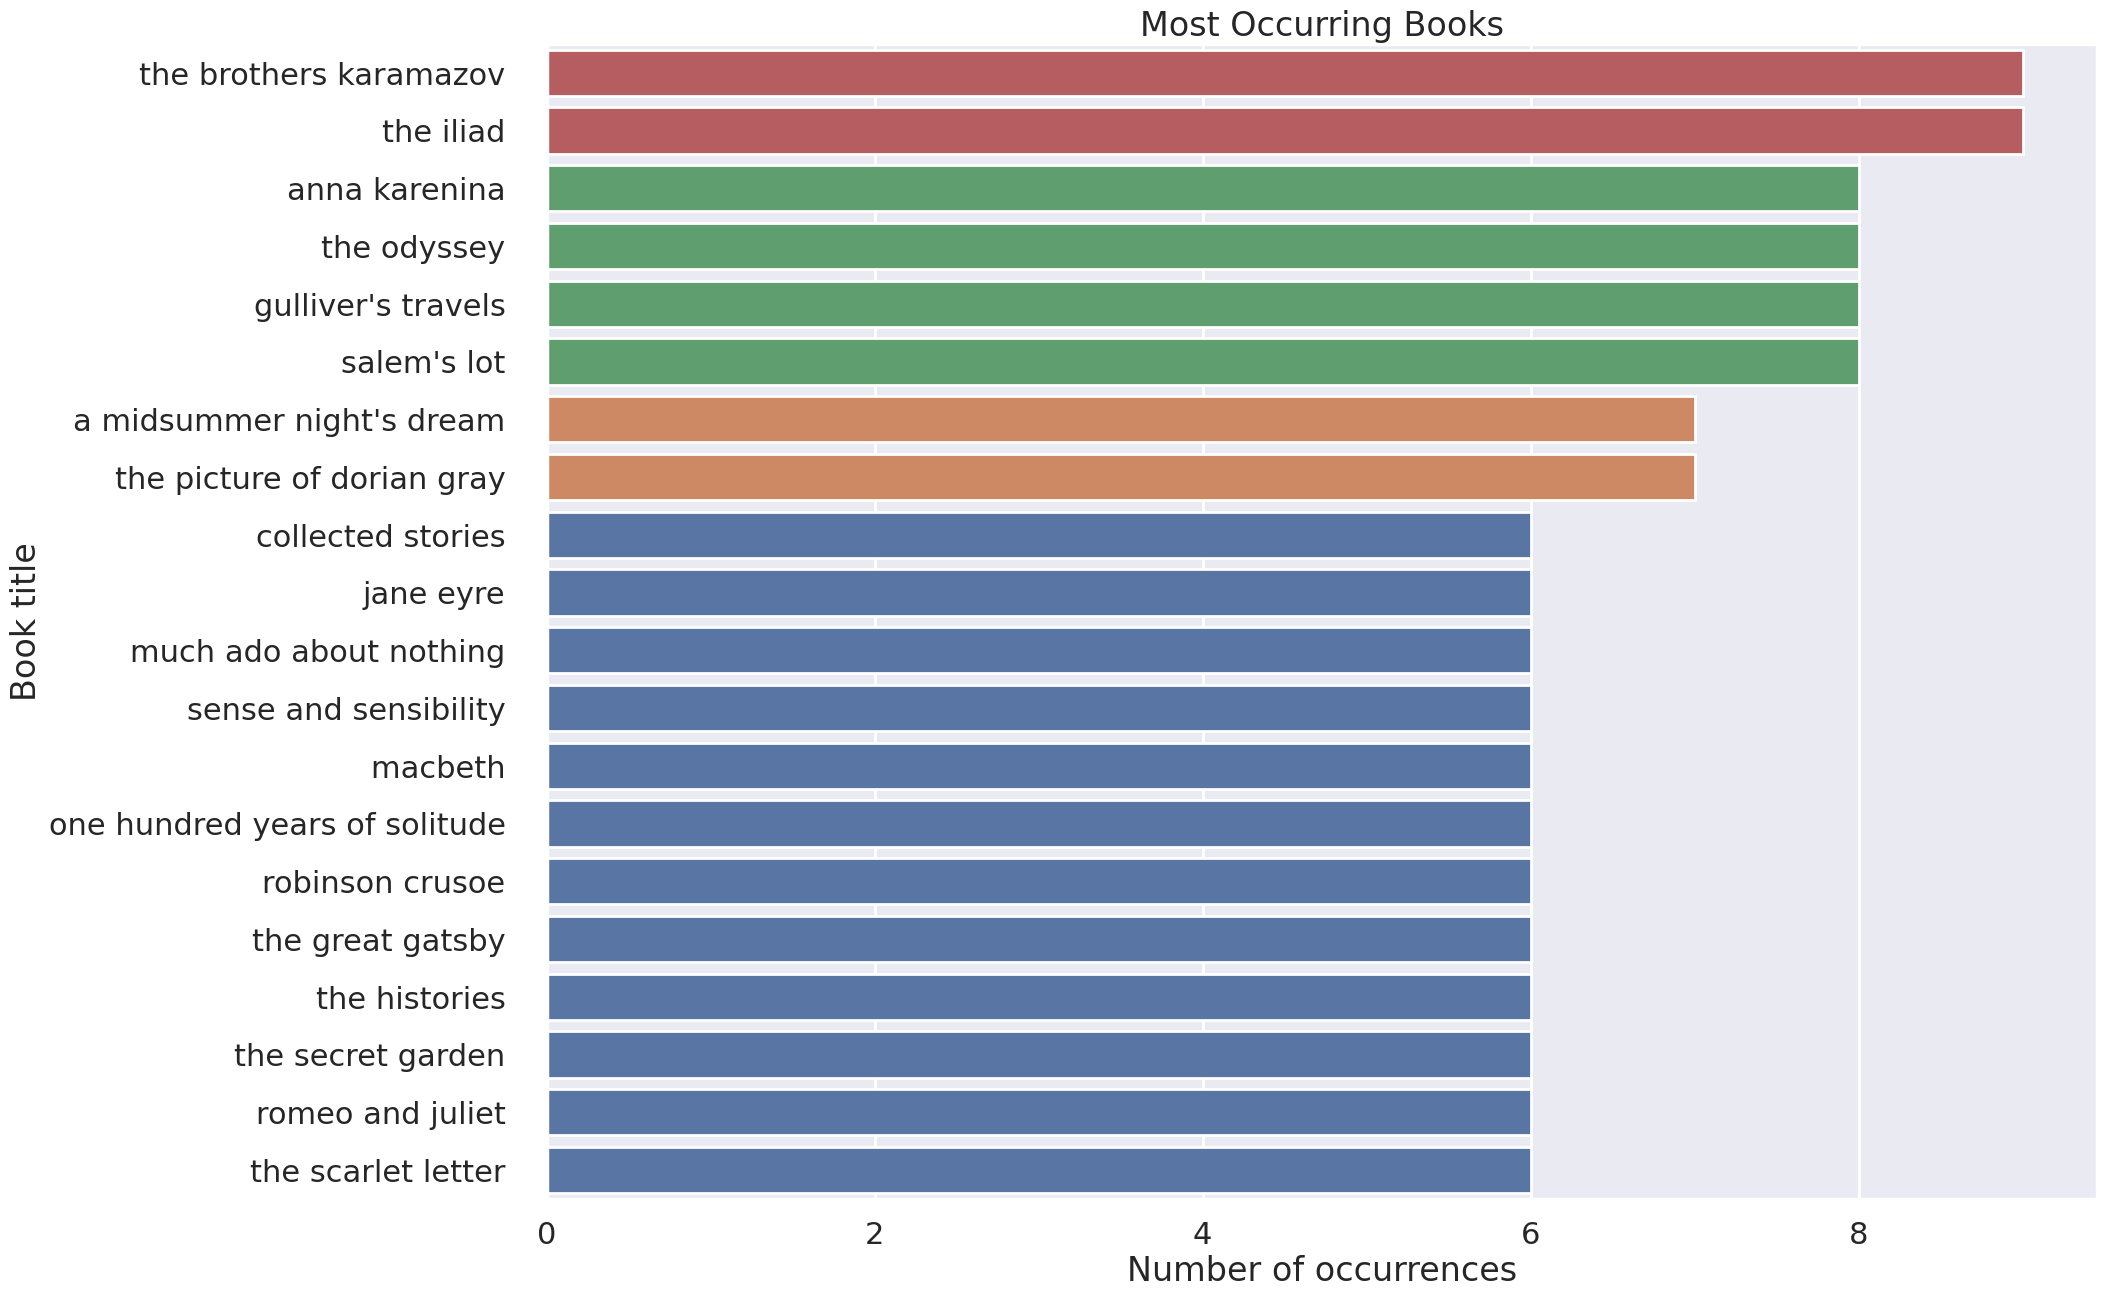

In [4]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = df_occurrences.Counter, y = df_occurrences.Title, orient="h", palette='deep', legend=False, hue=df_occurrences.Counter)
plt.title("Most Occurring Books")
plt.xlabel("Number of occurrences")
plt.ylabel("Book title")
plt.show()

## Rating distribution

In [5]:
hdfs_path = "hdfs://localhost:54310/user/ubuntu/dataset_preprocessed/"
schema = "Title string, Authors string, Avg_Rating float, ISBN13 string, Num_Pages integer, Ratings_Count integer, Text_Reviews_Count integer, Publisher string, Publication_Date date"

df_preprocessed = spark.read.csv(hdfs_path, header=False, inferSchema=False, sep=",", quote='', escape='', schema=schema)

print(df_preprocessed.describe("Avg_Rating").toPandas().to_markdown())

|    | summary   |   Avg_Rating |
|---:|:----------|-------------:|
|  0 | count     | 11123        |
|  1 | mean      |     3.93408  |
|  2 | stddev    |     0.350485 |
|  3 | min       |     0        |
|  4 | max       |     5        |


Text(0.5, 30.444444444444414, 'Average rating')

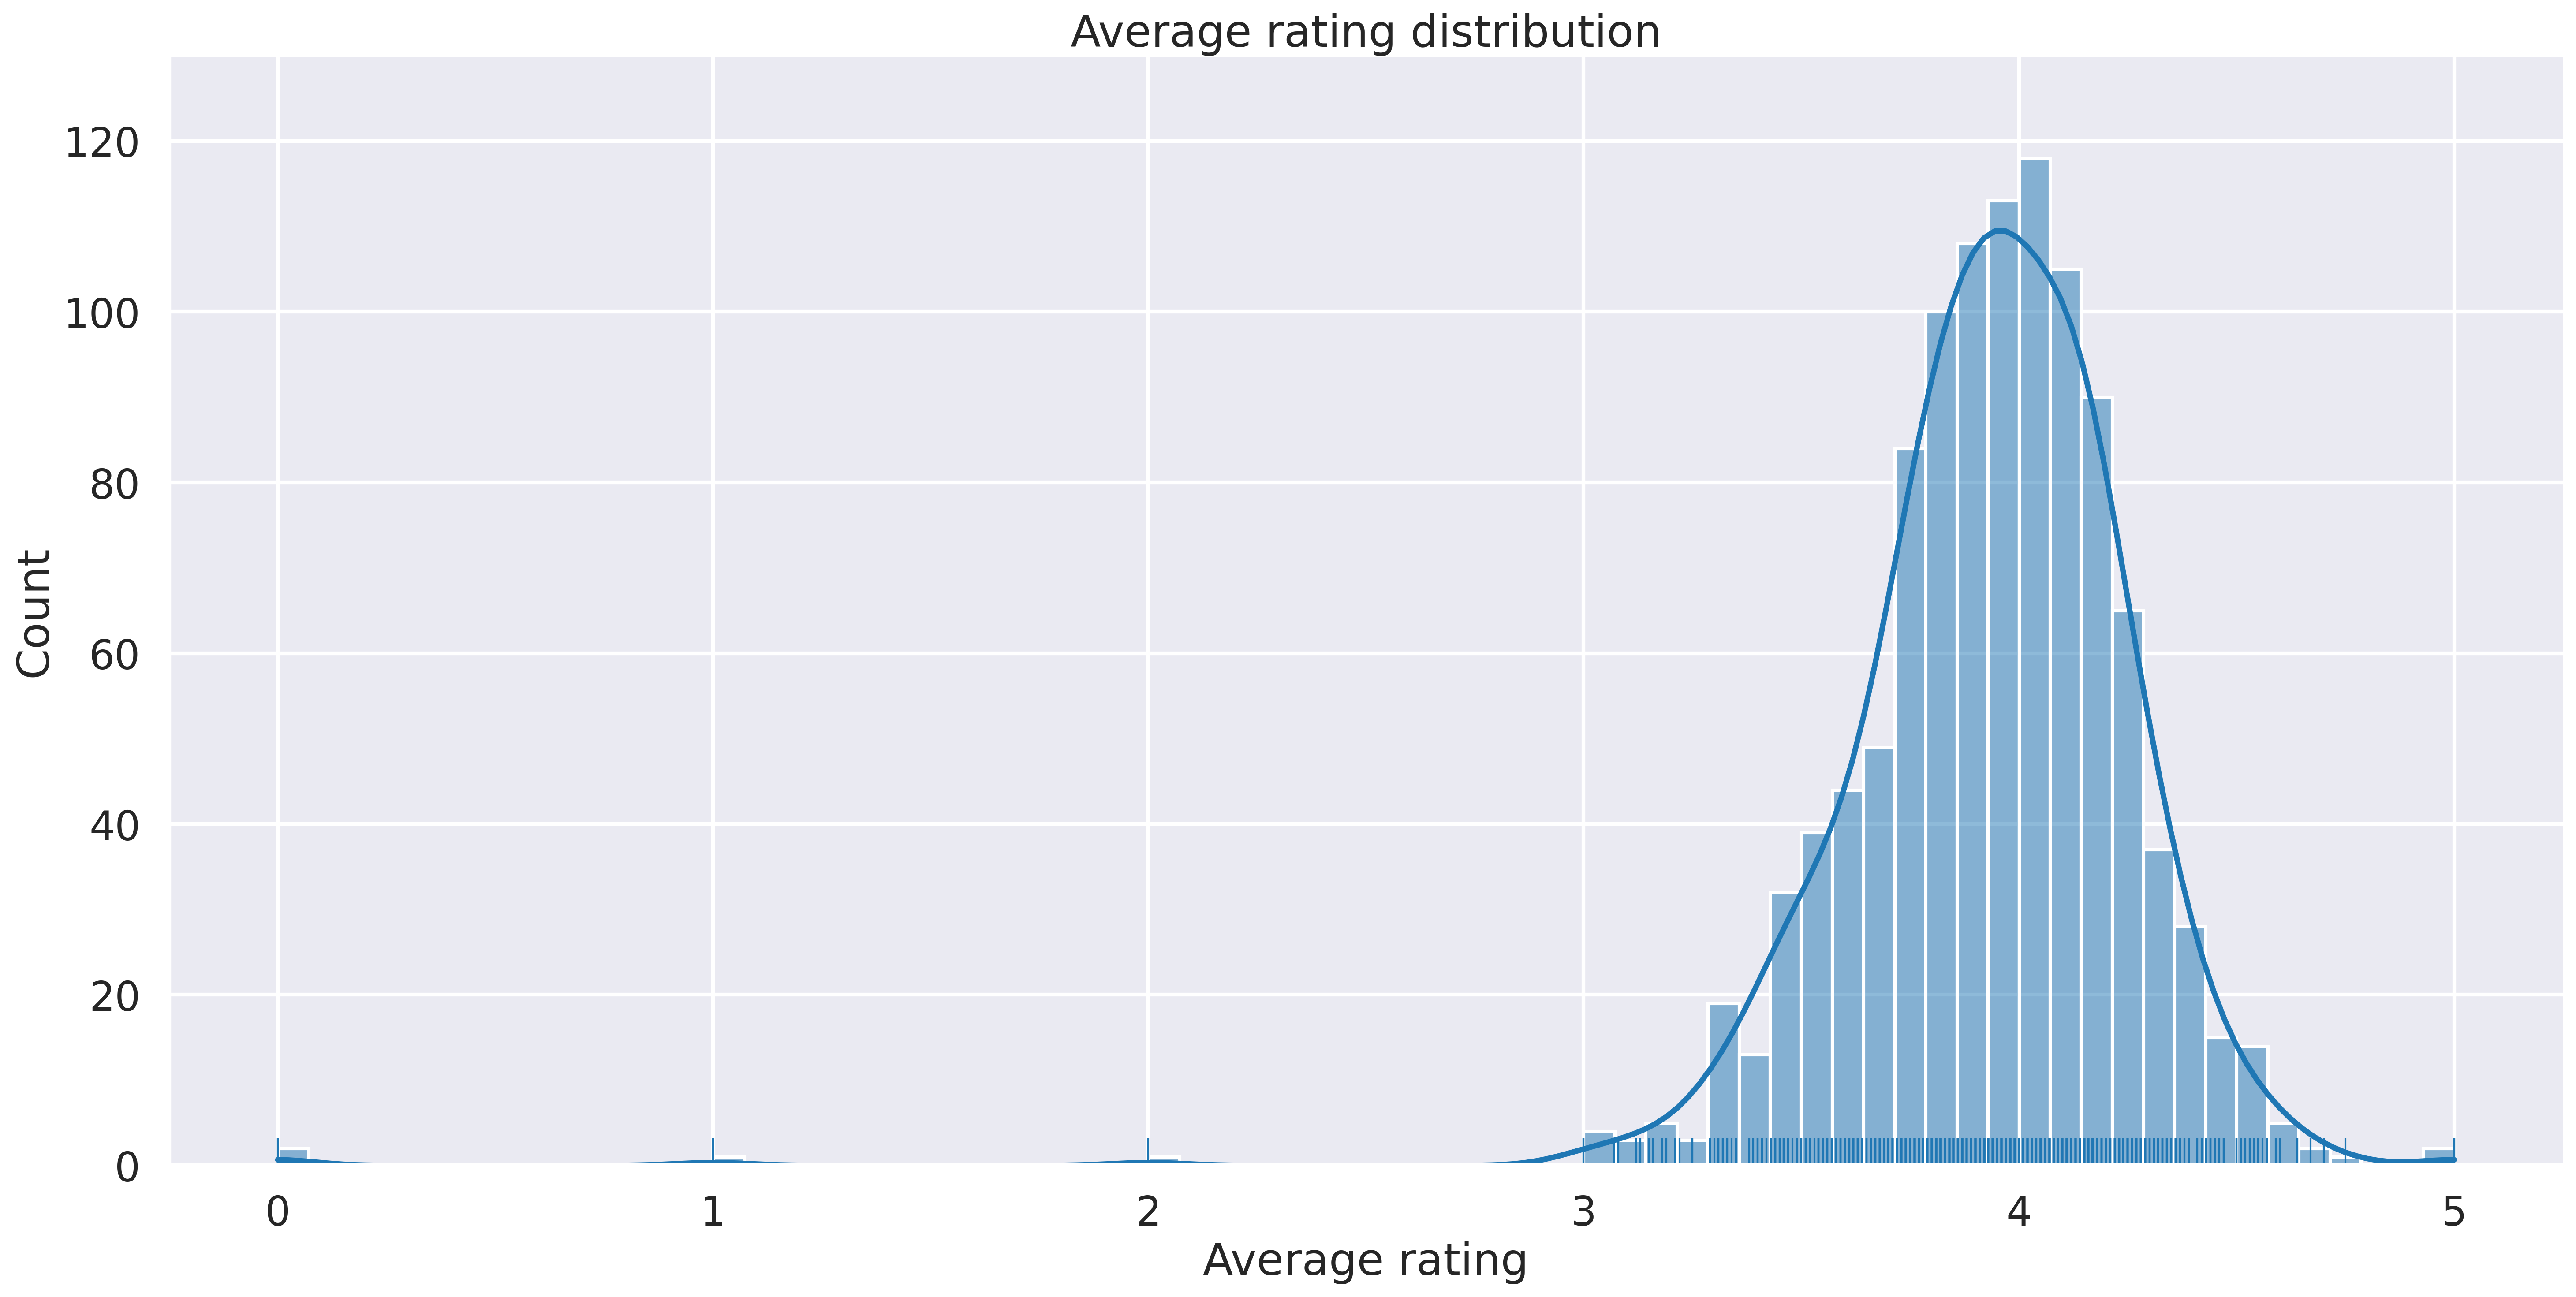

In [6]:
df_rating_sample = df_preprocessed.sample(fraction=0.1, seed=42).toPandas()

ax = sns.displot(data=df_rating_sample, x="Avg_Rating", kde=True, height=10, aspect=2, rug=True, legend=False)
ax.fig.set_dpi(300)
plt.title("Average rating distribution")
plt.xlabel("Average rating")

## Most prolific authors

In [7]:
df_authors_book_number = df_preprocessed.groupby("Authors").agg(count("Title").alias("Counter"))

df_authors_book_number = df_authors_book_number.sort(df_authors_book_number.Counter.desc()).limit(20).toPandas()

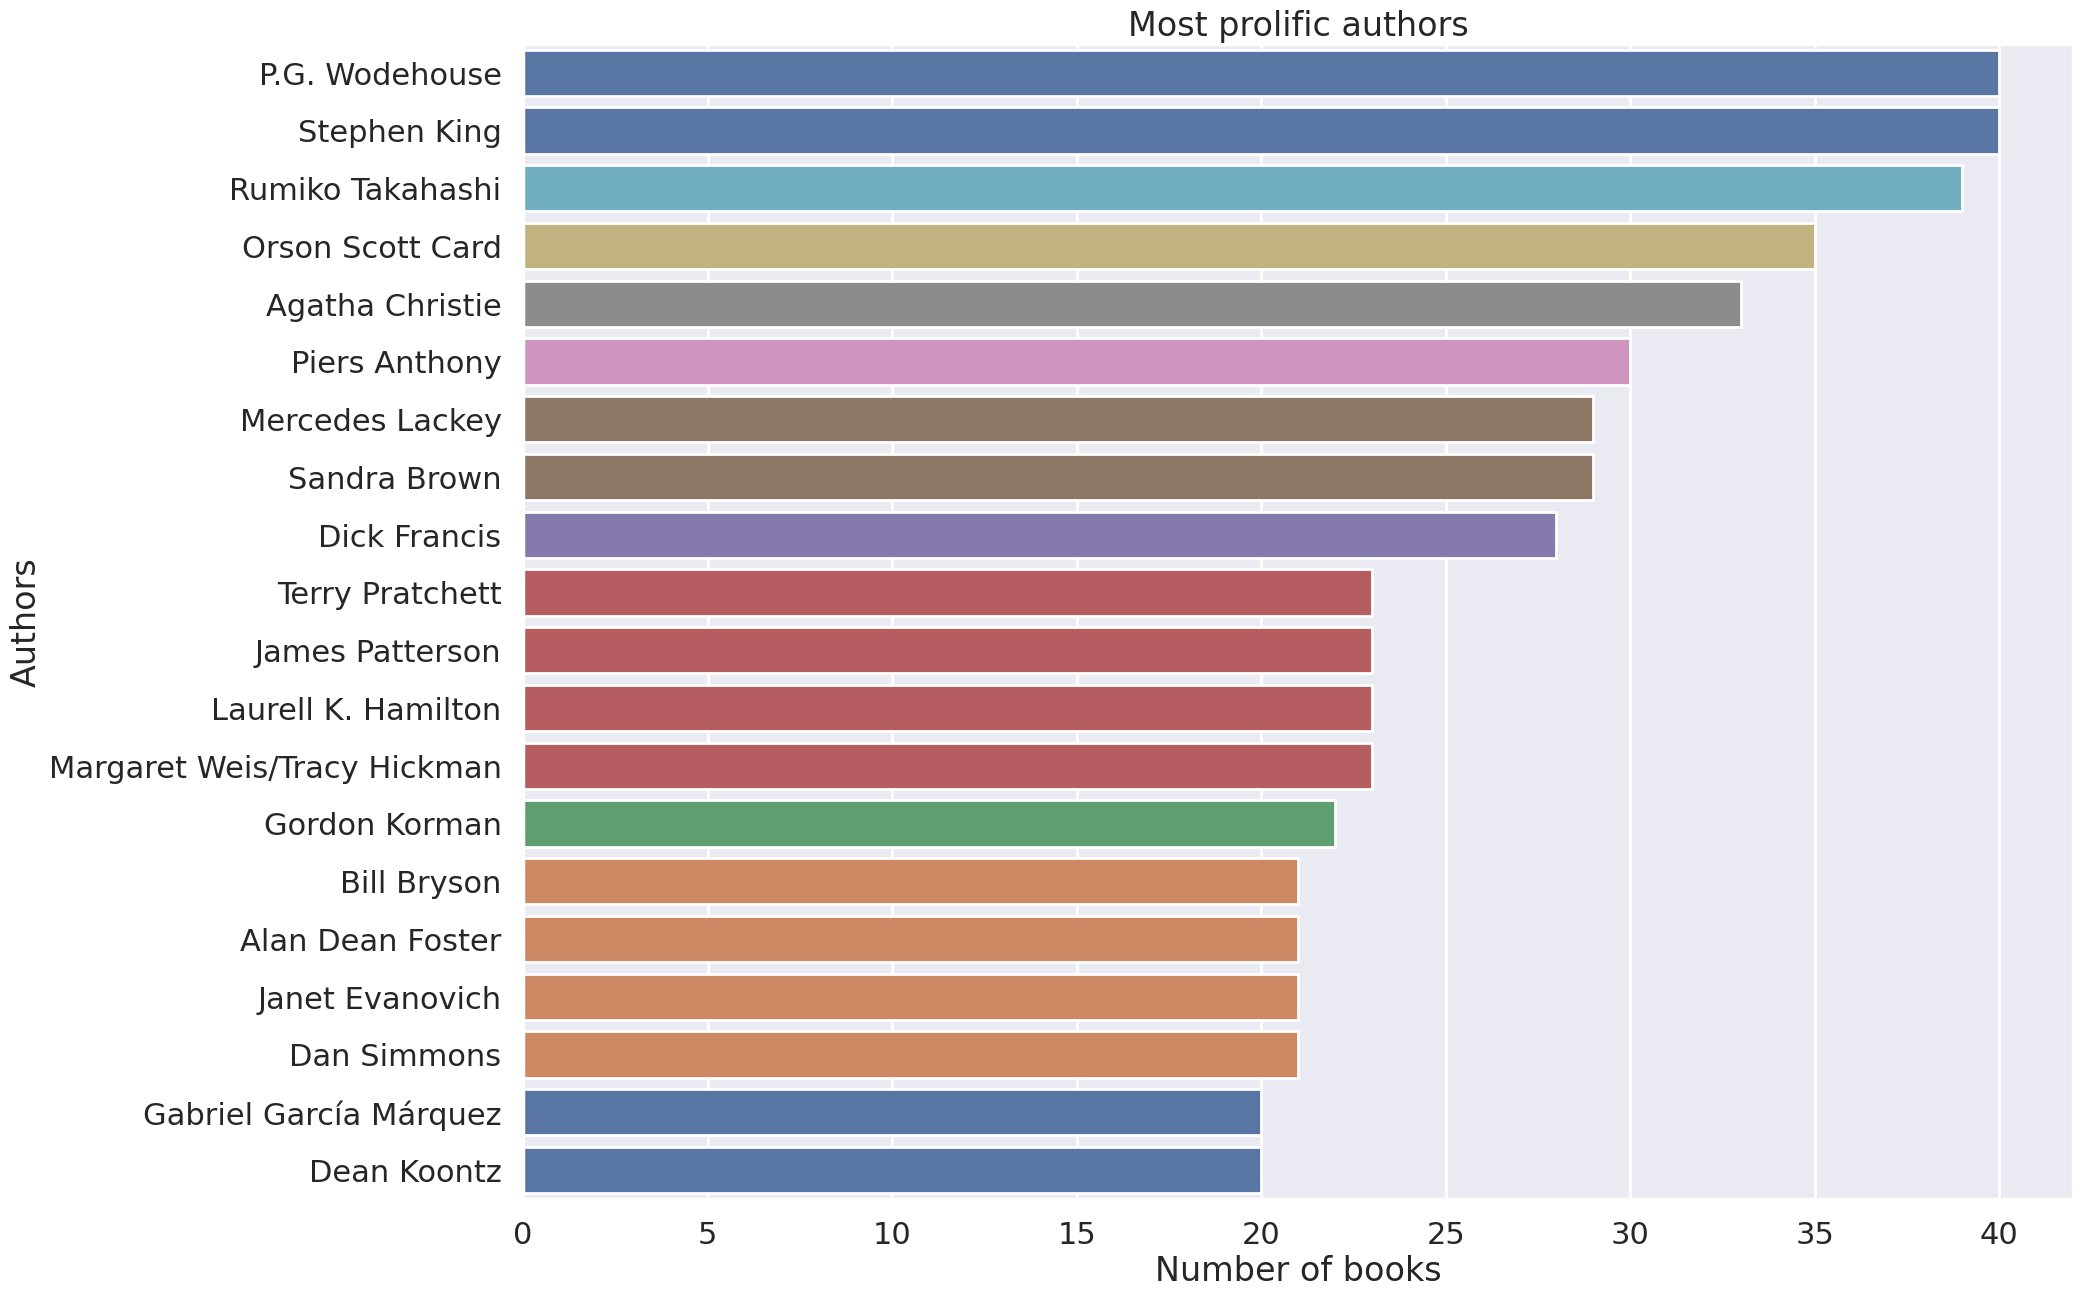

In [8]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = df_authors_book_number.Counter, y = df_authors_book_number.Authors, orient="h", palette='deep', legend=False, hue=df_authors_book_number.Counter)
plt.title("Most prolific authors")
plt.xlabel("Number of books")
plt.ylabel("Authors")
plt.show()

## Top rated books

In [9]:
df_top_rated_books = df_preprocessed.select('Title', 'Avg_Rating')
df_most_voted_books = df_preprocessed.select('Title', 'Ratings_Count')
df_most_reviewed_books = df_preprocessed.select('Title', 'Text_Reviews_Count')

df_top_rated_books = df_top_rated_books.sort(df_top_rated_books.Avg_Rating.desc()).limit(20).toPandas()
df_most_voted_books = df_most_voted_books.sort(df_most_voted_books.Ratings_Count.desc()).limit(20).toPandas()
df_most_reviewed_books = df_most_reviewed_books.sort(df_most_reviewed_books.Text_Reviews_Count.desc()).limit(20).toPandas()

### Highest rated

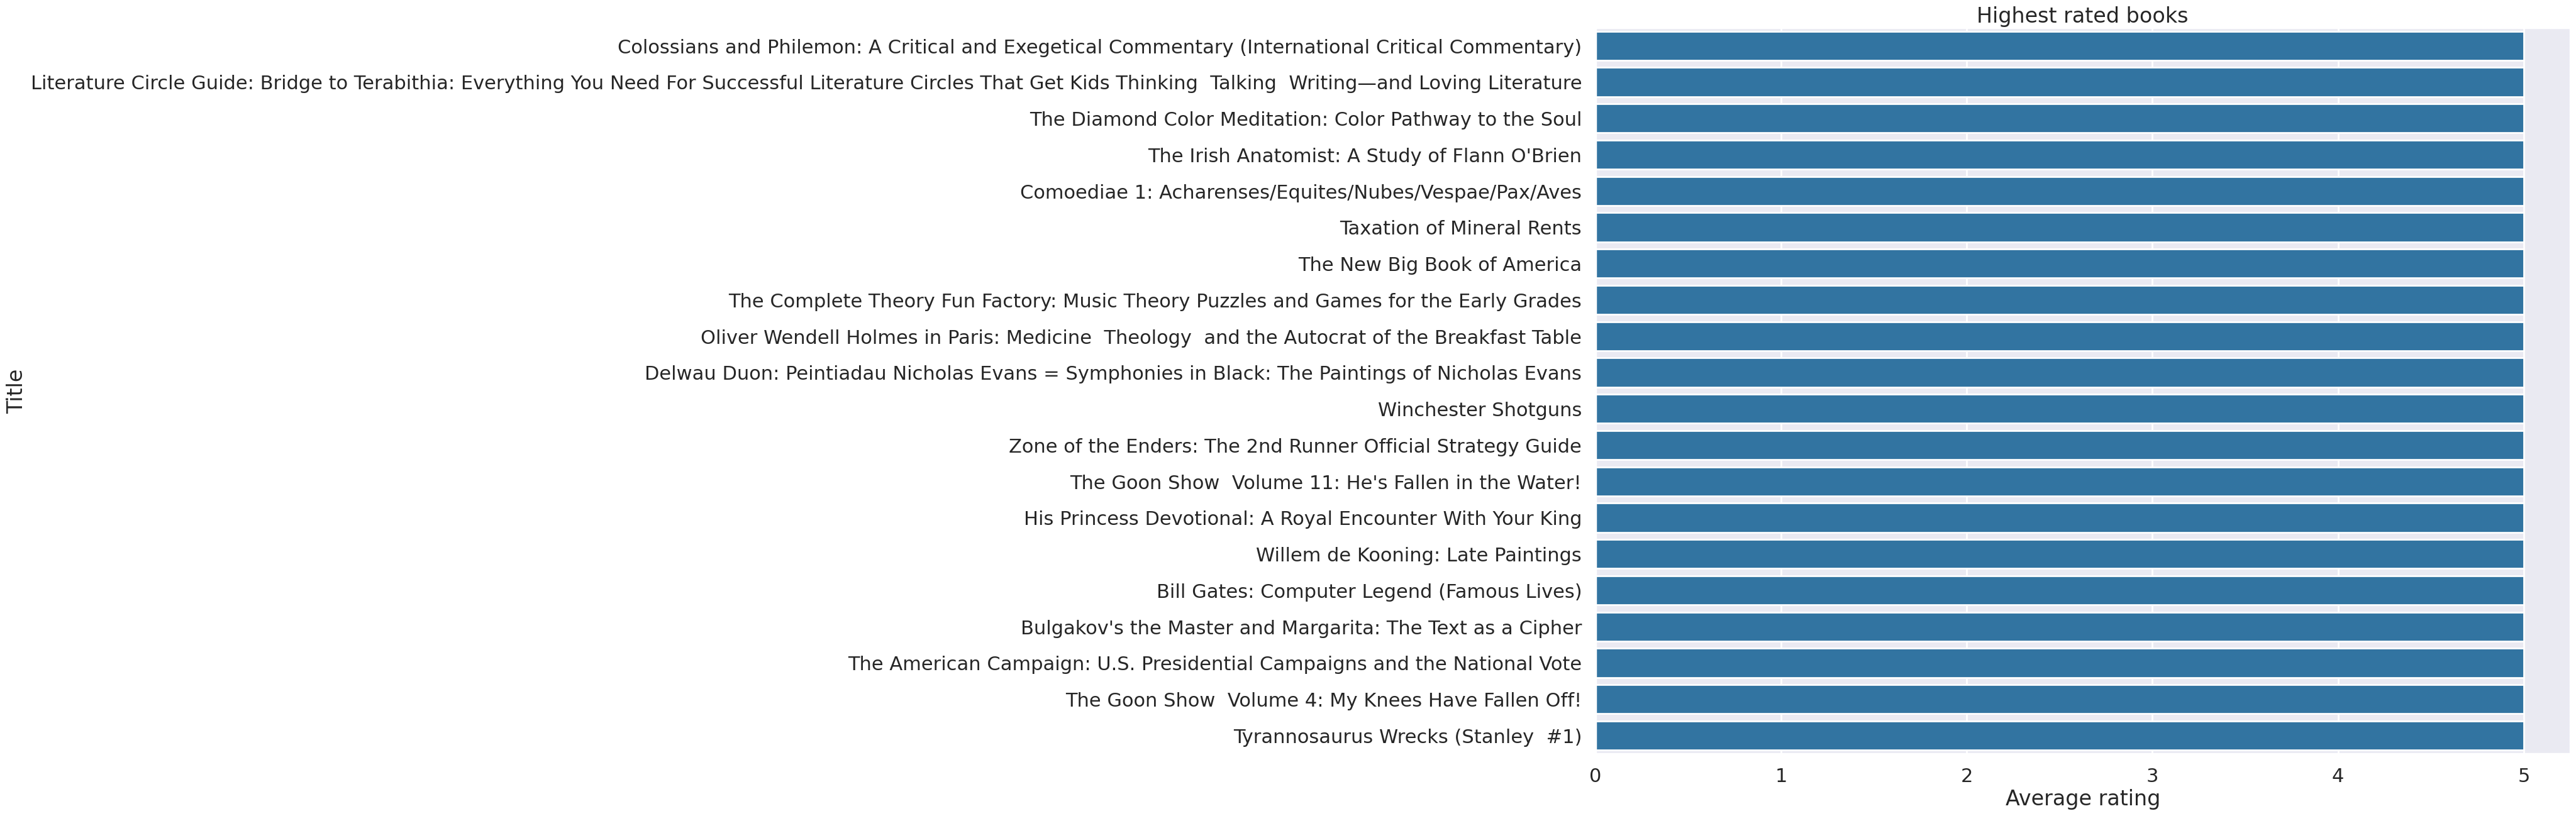

In [10]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = df_top_rated_books.Avg_Rating, y = df_top_rated_books.Title, orient="h")
plt.title("Highest rated books")
plt.xlabel("Average rating")
plt.ylabel("Title")
plt.show()

### Most voted

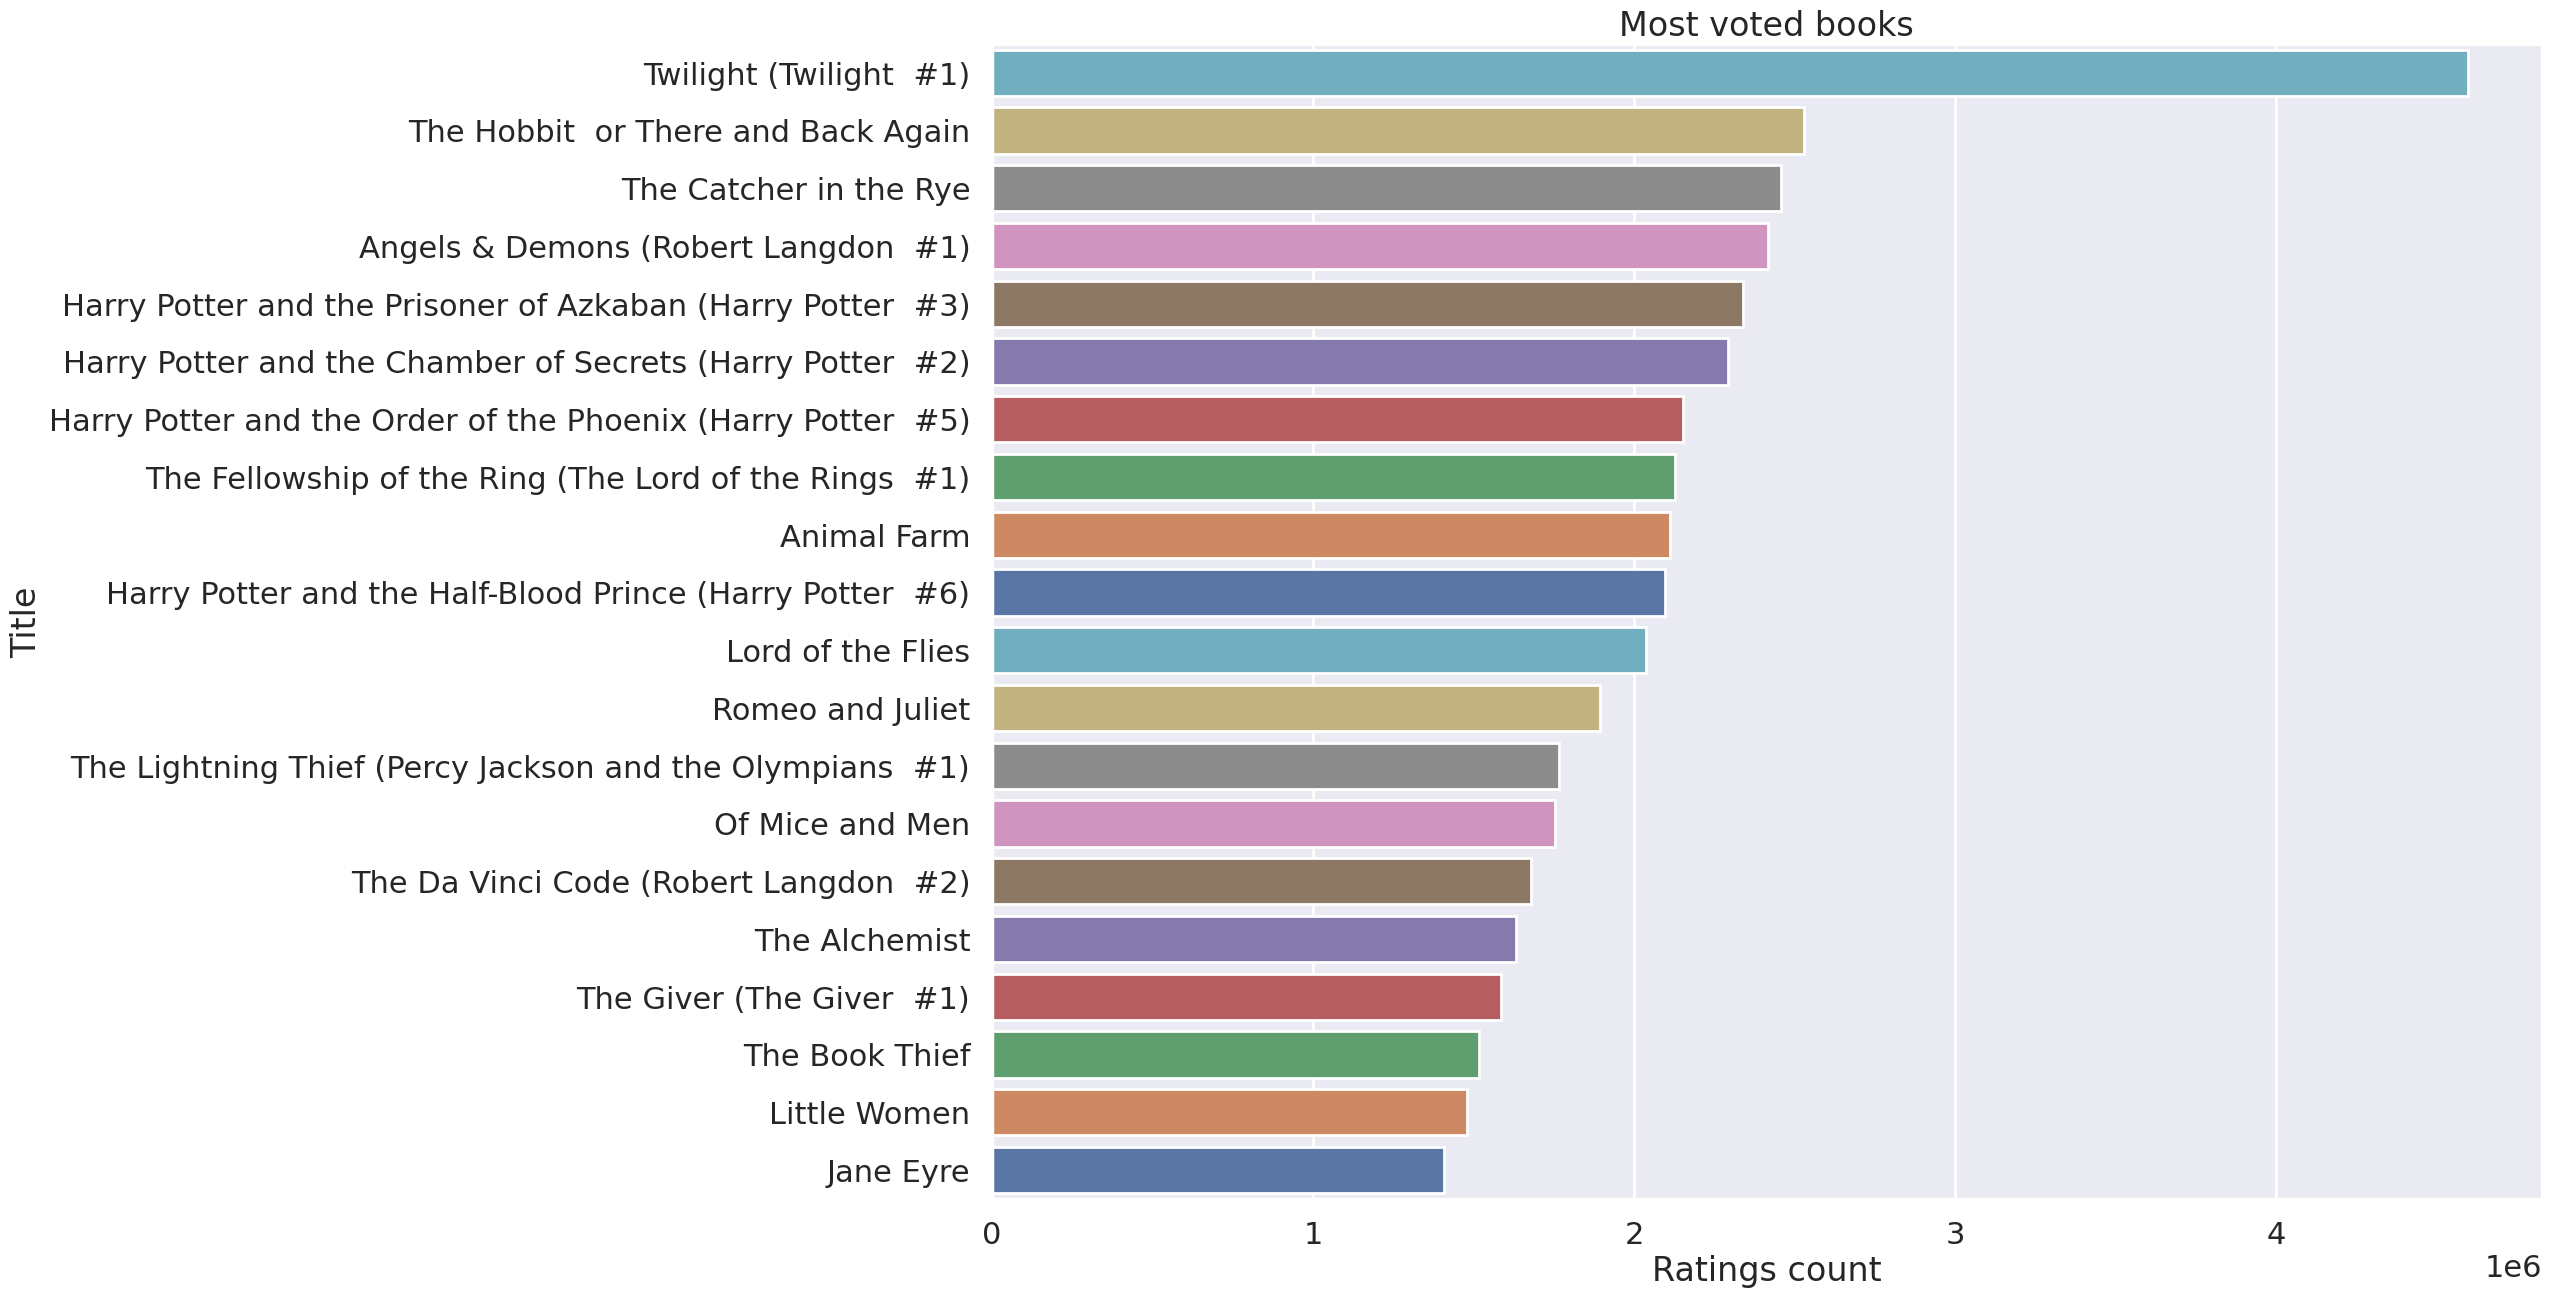

In [11]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = df_most_voted_books.Ratings_Count, y = df_most_voted_books.Title, orient="h", palette='deep', legend=False, hue=df_most_voted_books.Ratings_Count)
plt.title("Most voted books")
plt.xlabel("Ratings count")
plt.ylabel("Title")
plt.show()

#### Word cloud

(-0.5, 1199.5, 799.5, -0.5)

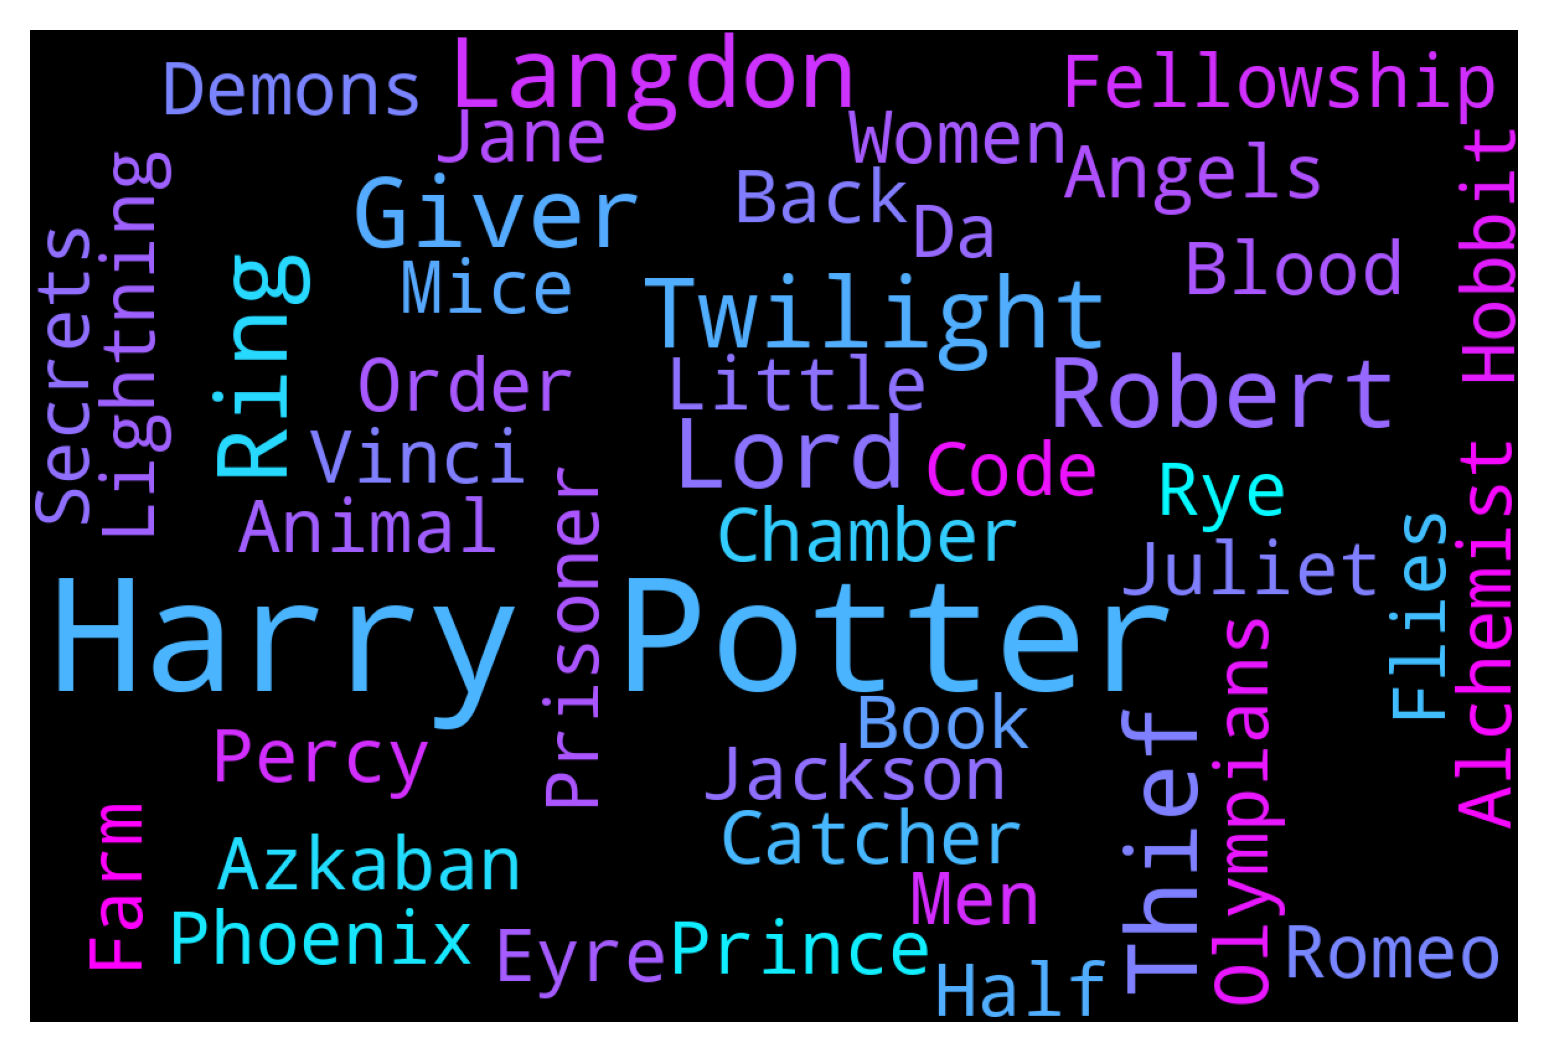

In [36]:
from wordcloud import WordCloud

titles=""

for title in df_most_voted_books.Title:
  titles+=" "+title

plt.figure(dpi=300)
wc = WordCloud(colormap="cool_r" , width=1200, height=800).generate(titles)
plt.imshow(wc)
plt.axis("off")

### Most reviewed

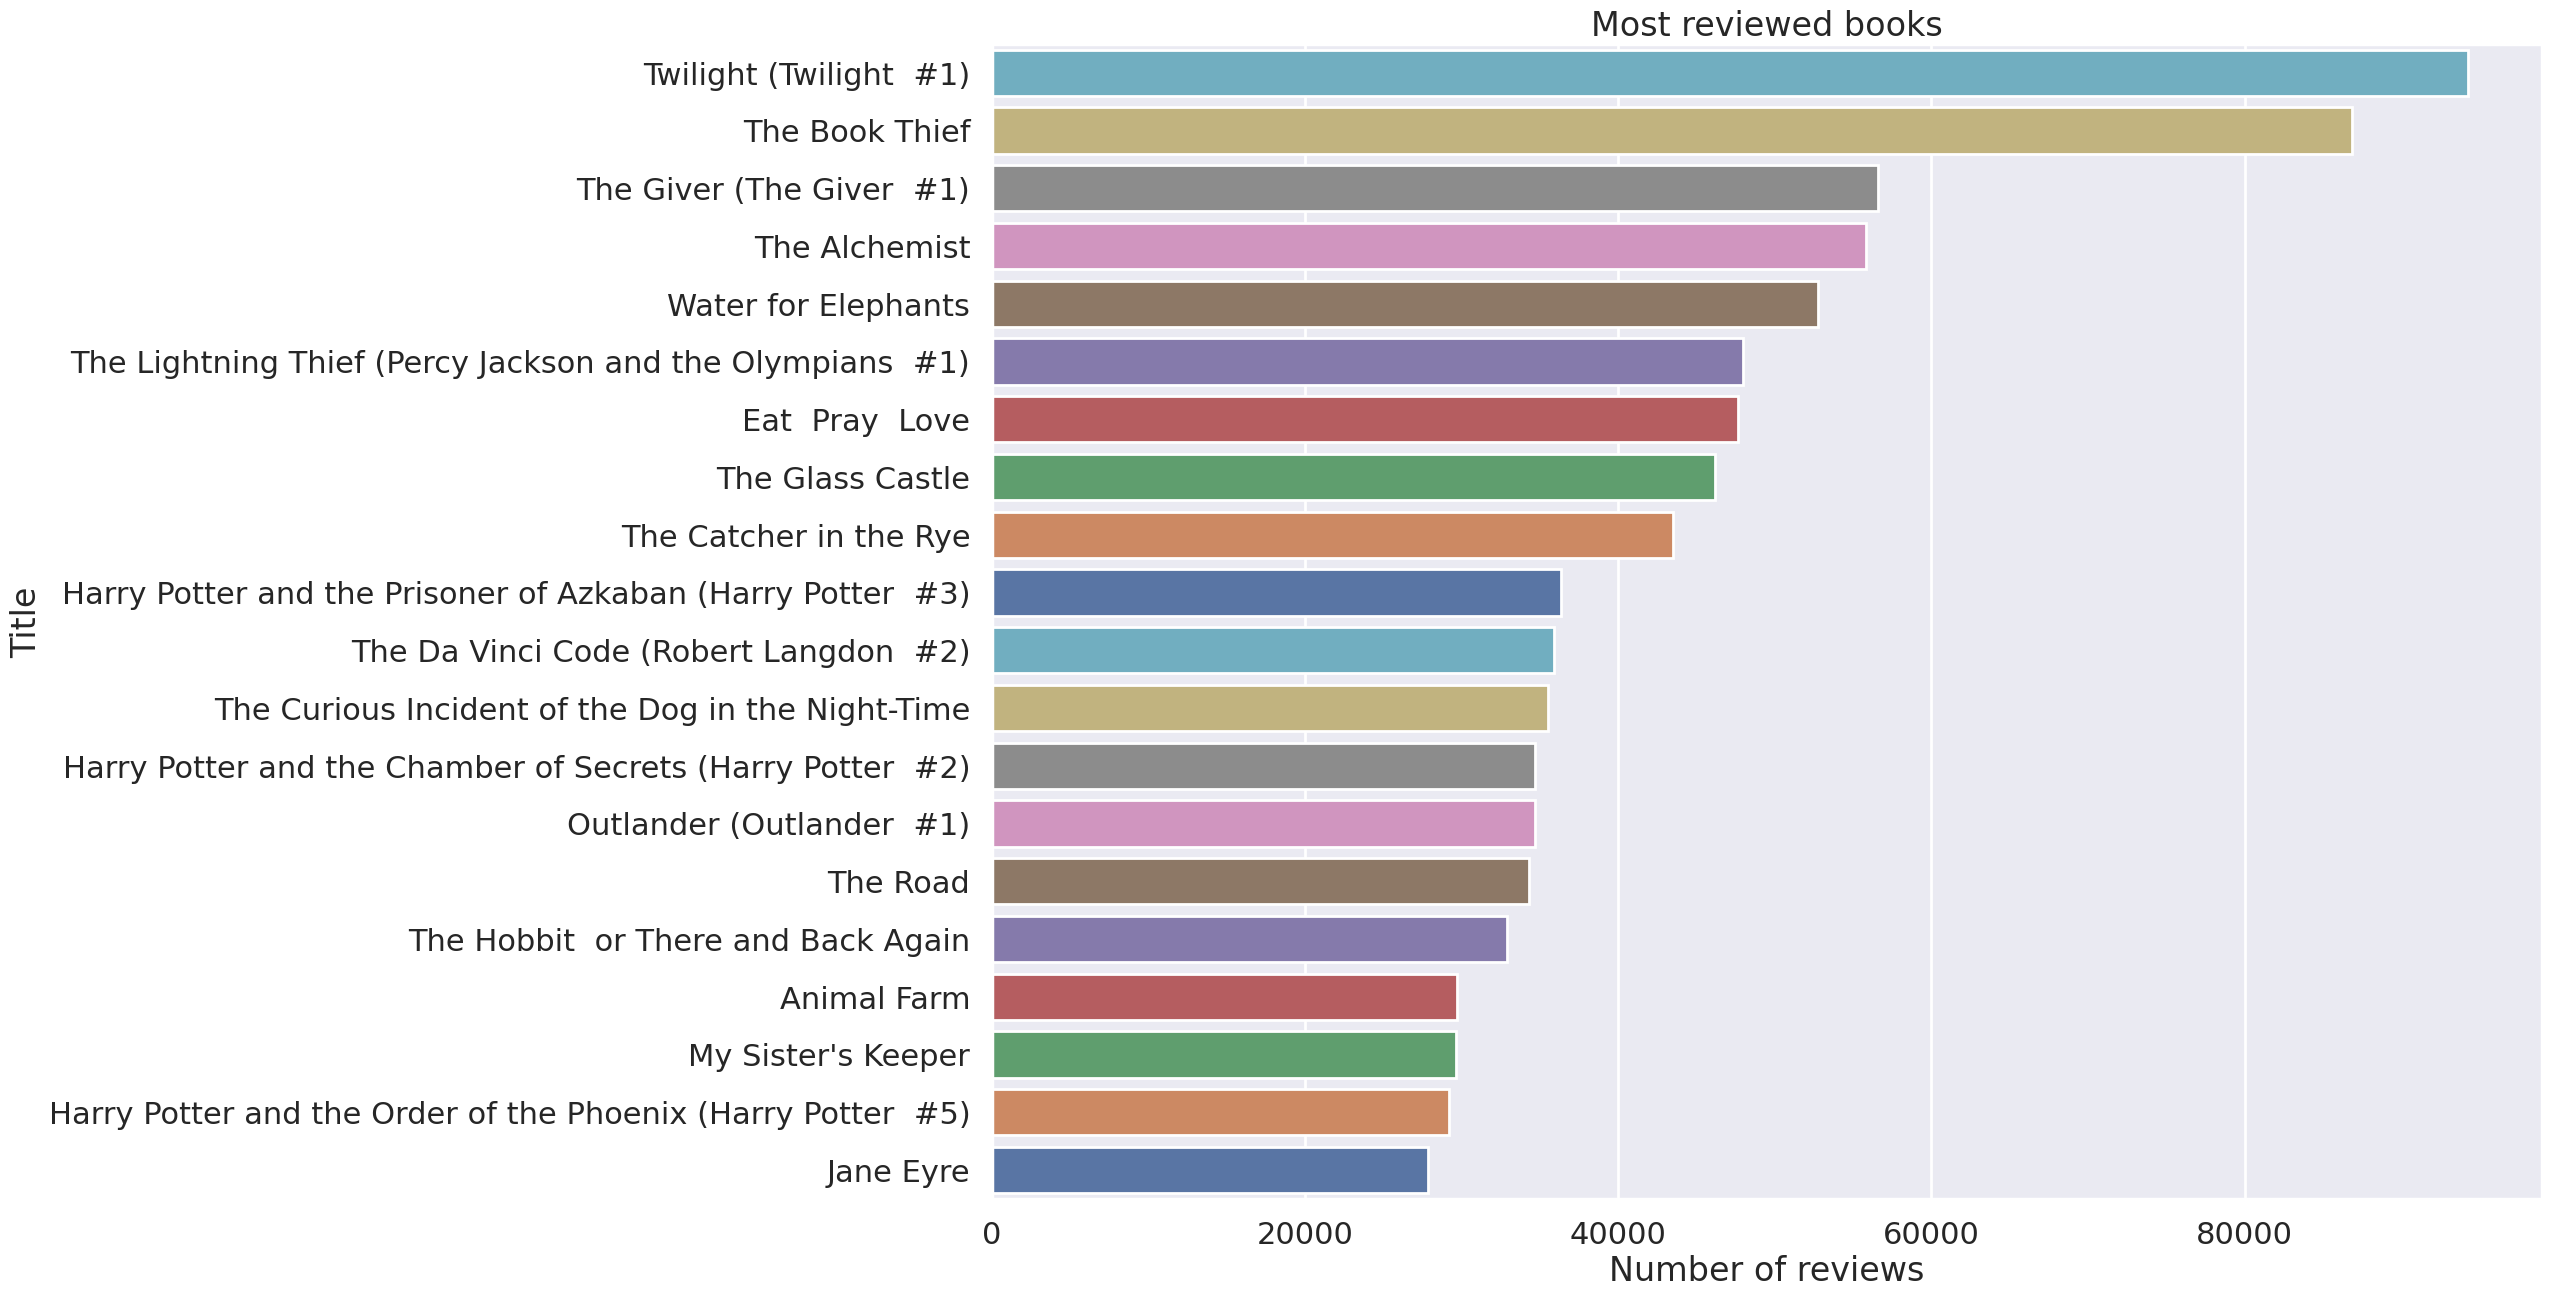

In [13]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = df_most_reviewed_books.Text_Reviews_Count, y = df_most_reviewed_books.Title, orient="h", palette='deep', legend=False, hue=df_most_reviewed_books.Text_Reviews_Count)
plt.title("Most reviewed books")
plt.xlabel("Number of reviews")
plt.ylabel("Title")
plt.show()

#### Word cloud

(-0.5, 1199.5, 799.5, -0.5)

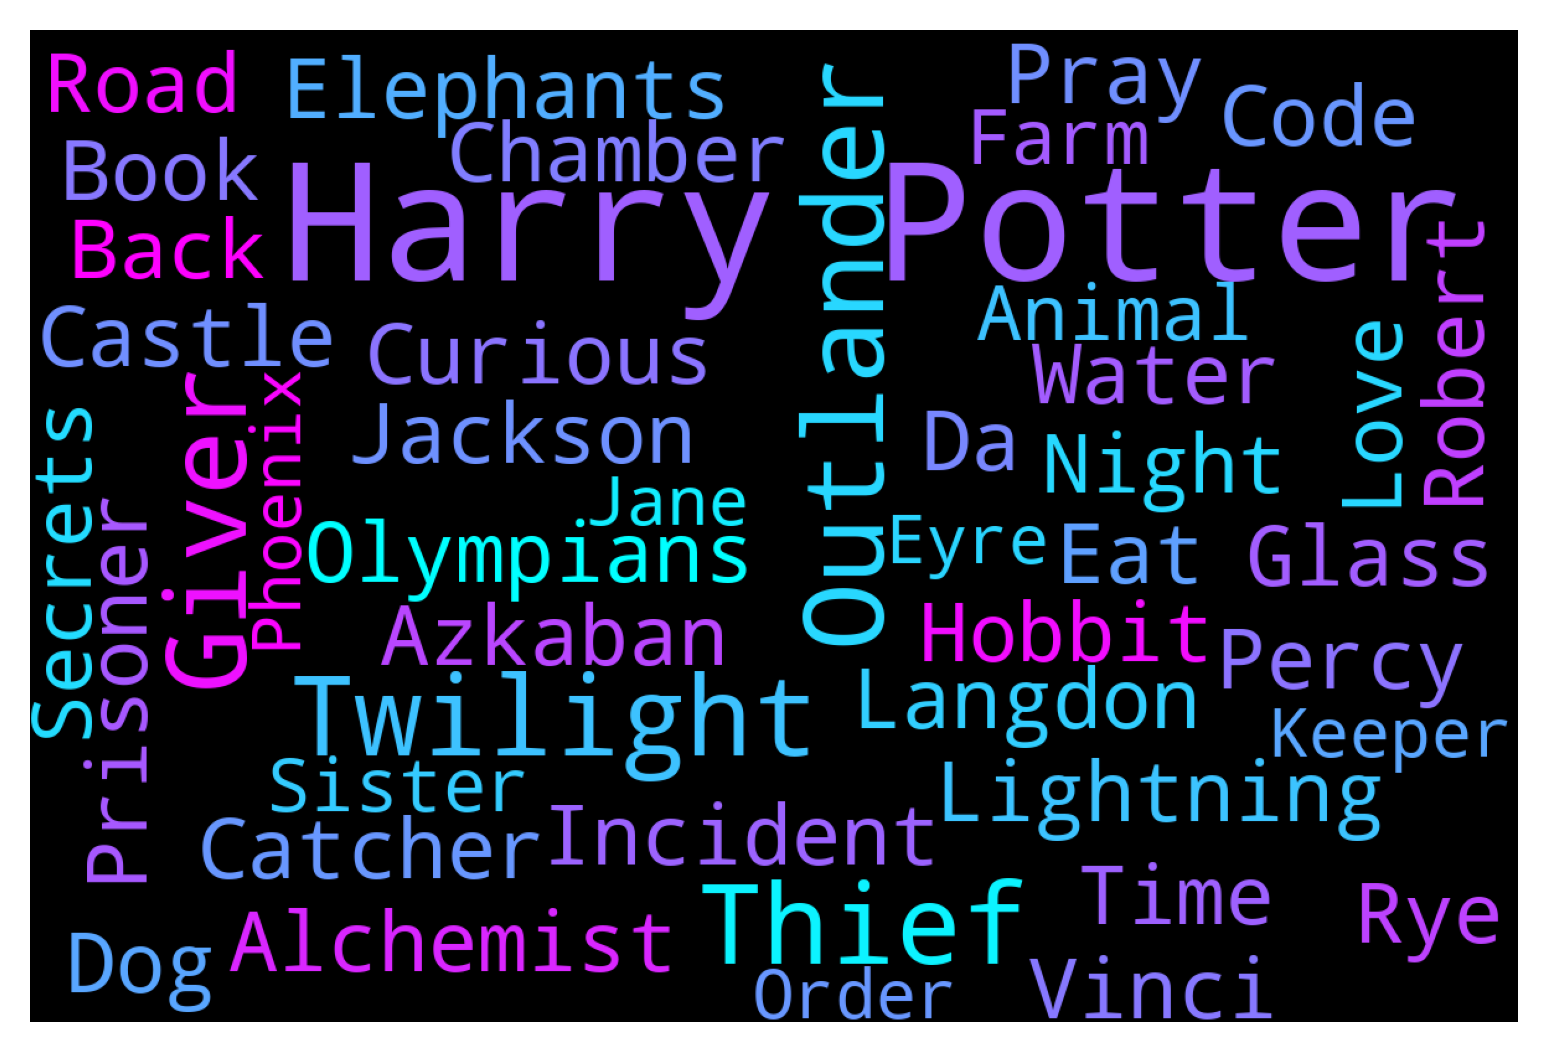

In [35]:
from wordcloud import WordCloud

titles=""

for title in df_most_reviewed_books.Title:
  titles+=" "+title

plt.figure(dpi=300)
wc = WordCloud(colormap="cool_r" , width=1200, height=800).generate(titles)
plt.imshow(wc)
plt.axis("off")

## Longest books

In [14]:
df_books_pages = df_preprocessed.select('Title', 'Num_Pages')

df_longest_books = df_books_pages.sort(df_books_pages.Num_Pages.desc()).limit(20).toPandas()

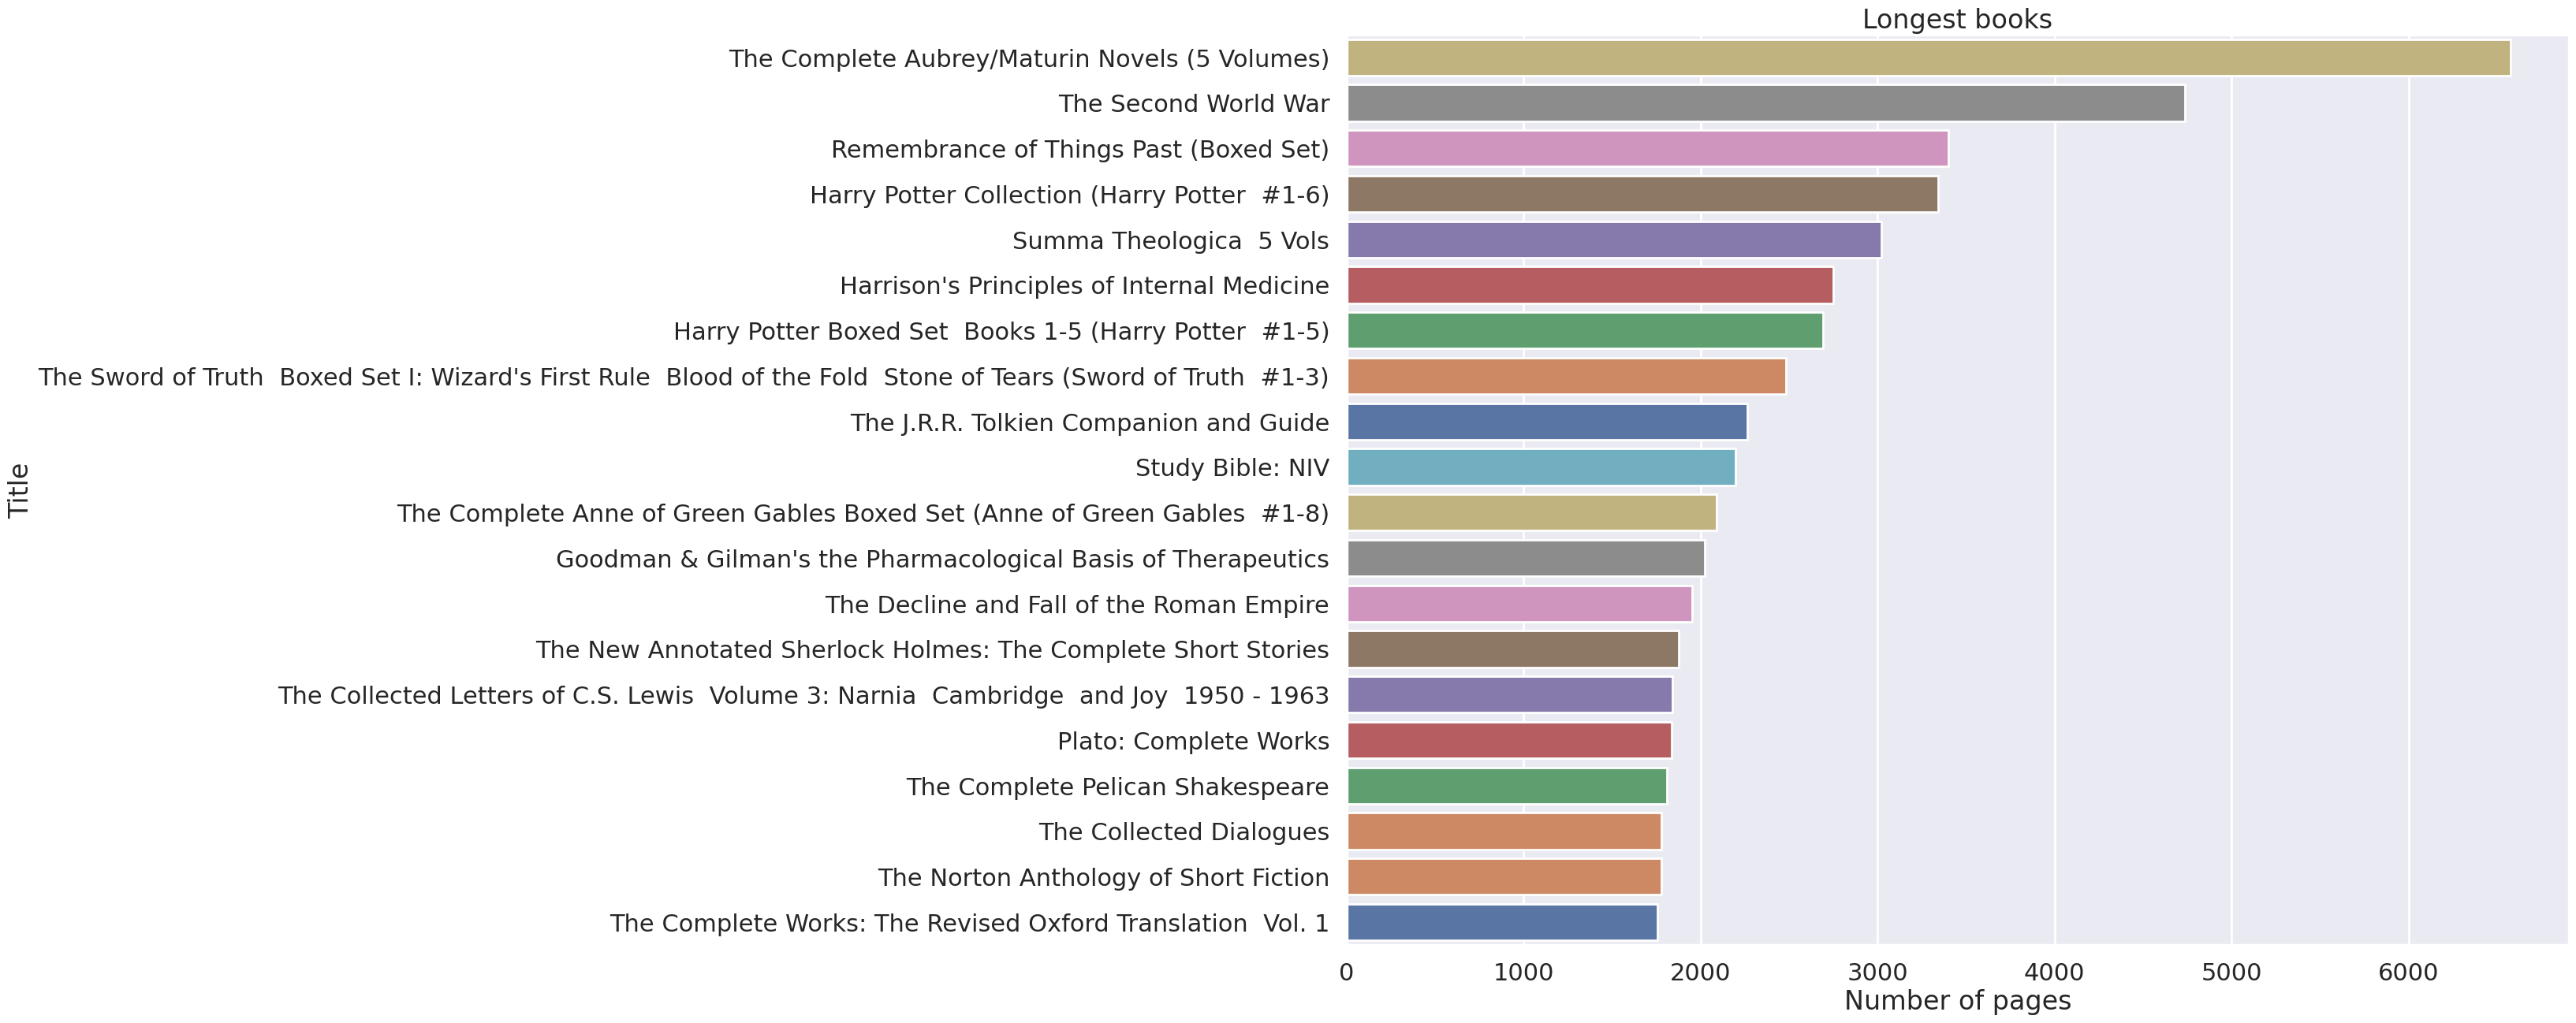

In [15]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = df_longest_books.Num_Pages, y = df_longest_books.Title, orient="h", palette='deep', legend=False, hue=df_longest_books.Num_Pages)
plt.title("Longest books")
plt.xlabel("Number of pages")
plt.ylabel("Title")
plt.show()

## Most prolific publishers

In [16]:
df_publisher_book_number = df_preprocessed.groupby("Publisher").agg(count("Title").alias("Counter"))

df_publisher_book_number = df_publisher_book_number.sort(df_publisher_book_number.Counter.desc()).limit(20).toPandas()

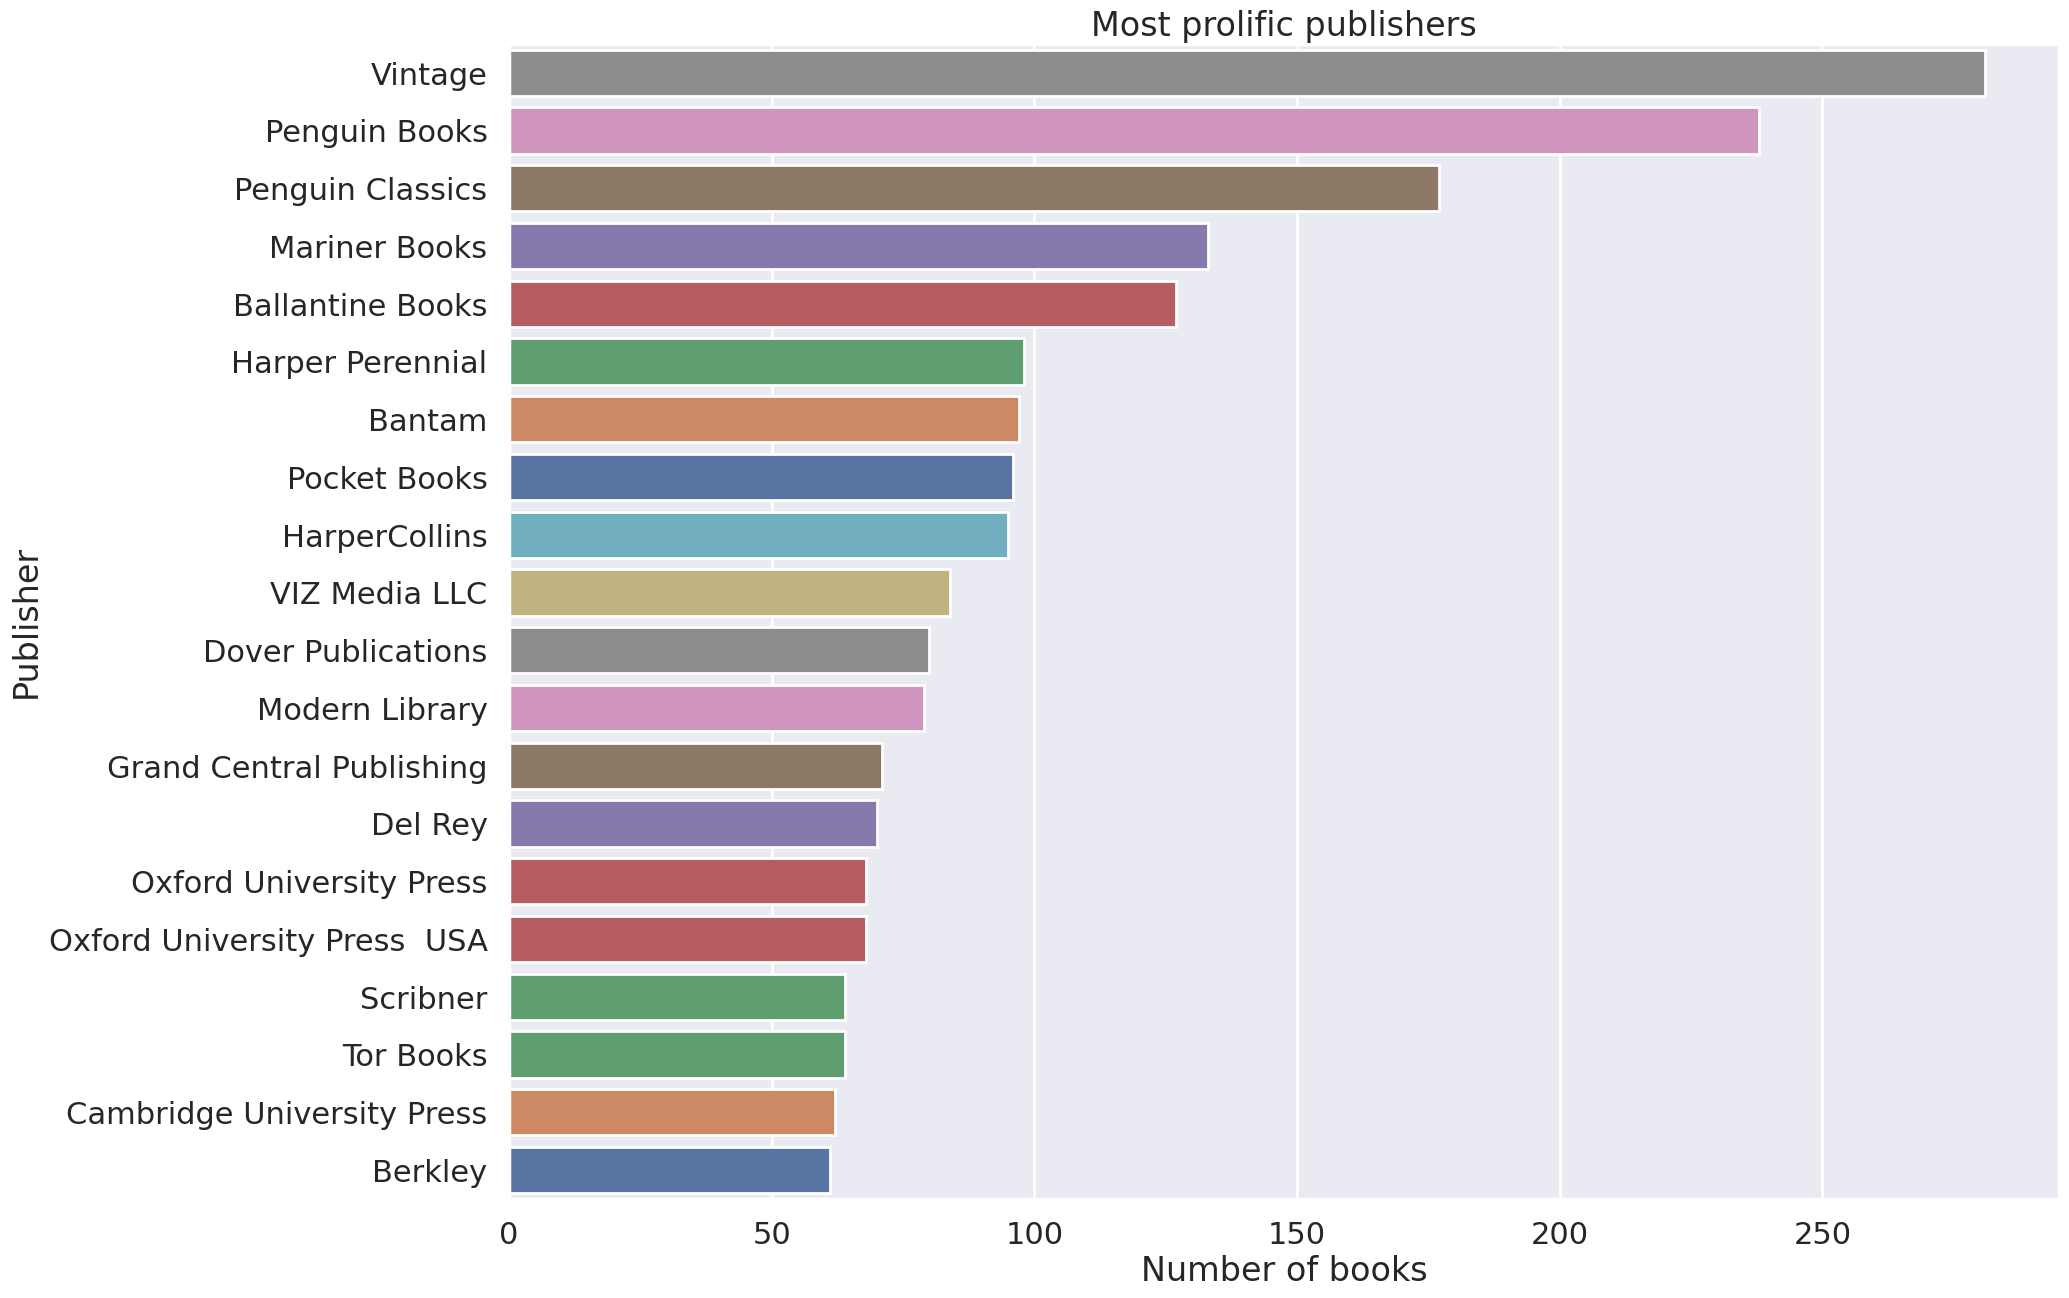

In [17]:
sns.set_context('poster')
plt.figure(figsize=(20, 15))
sns.barplot(x=df_publisher_book_number.Counter, y=df_publisher_book_number.Publisher, orient="h", palette='deep',
            legend=False, hue=df_publisher_book_number.Counter)
plt.title("Most prolific publishers")
plt.xlabel("Number of books")
plt.ylabel("Publisher")
plt.show()

In [18]:
sc.stop()